#### In this notebook, Sentiment analysis will be performed using DistilBERT with Huggingface Pytorch library. To build a sentiment classifier, we scraped reviews for Top 30 Android apps in India from Google Play store using Google play scraper.

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Import the required libraries**

In [ ]:
#Install packages
!pip install --q transformers
!pip install watermark

     |████████████████████████████████| 2.9 MB 5.4 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 895 kB 36.9 MB/s 
     |████████████████████████████████| 636 kB 44.0 MB/s 
     |████████████████████████████████| 3.3 MB 35.9 MB/s 
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.8.1
    Uninstalling importlib-metadata-4.8.1:
      Successfully uninstalled importlib-metadata-4.8.1


In [ ]:
!pip install scikit-plot

In [ ]:
#Check installed version of packages
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.9.0+cu102
transformers: 4.11.0



In [ ]:
#Import required libraries 
import pandas as pd
import numpy as np
import time
import datetime
import seaborn as sns
from matplotlib import rc
from pylab import rcParams
import matplotlib.pyplot as plt
from textwrap import wrap
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve,auc
from tqdm.notebook import tqdm

from babel.dates import format_time

import transformers
from transformers import DistilBertModel, DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader,TensorDataset, RandomSampler, SequentialSampler
import torch.nn as nn  
import torch.nn.functional as F  
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu');

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid',palette='muted',font_scale=1.2)
color_palette=['#01BEFE','#FFDD00','#FF7D00','#FF006D','#ADFF02','#8F00FF']
sns.set_palette(sns.color_palette(color_palette))

rcParams['figure.figsize']= 12,6

import warnings
warnings.filterwarnings('ignore')

seed=42
np.random.seed(seed)
torch.manual_seed(seed)

#### Check GPU info on Google colab

In [ ]:
!nvidia-smi

Wed Sep 29 09:08:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    29W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Google colab is using Tesla K80 gpu.

### Now load the scraped dataset

In [ ]:
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/App_reviews.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOE2Yr0uRwtSM19o3qq9rmIciKMII4oWvQ4X-TV...,Pankaj meena,https://lh3.googleusercontent.com/a-/AOh14GiBW...,wow,5,0,NaN,2020-08-10 03:15:48,NaN,NaN,newest,0
1,gp:AOqpTOEyZPR2_epCDBjuEGkFxMN8Uz7uqe8vju5pDDW...,Jesna sinaan Sinaan,https://lh3.googleusercontent.com/-KFcL-CA2eWY...,Super,5,0,NaN,2020-08-10 03:15:47,NaN,NaN,newest,0
2,gp:AOqpTOGTrphID0mo58x978-3DDrGXp_oilgqTtrkHvO...,Manoj Verma,https://lh3.googleusercontent.com/-wi1U7m9JVYU...,Majna verna,5,0,NaN,2020-08-10 03:15:44,NaN,NaN,newest,0
3,gp:AOqpTOH-6Qcb54ZFIl4MJon9dFtQHjHpLbSTFmw92P8...,MUKESH KUMAR DHRUW,https://lh3.googleusercontent.com/-nEokiW8fSXA...,Nice app,5,0,NaN,2020-08-10 03:14:51,NaN,NaN,newest,0
4,gp:AOqpTOGX6kF5IAfLaY_ZxwA7PvPwyxONwGN24JM0jrx...,Ananya Adak,https://lh3.googleusercontent.com/a-/AOh14Gi5w...,Nice,5,0,2.7.3.156,2020-08-10 03:14:42,NaN,NaN,newest,0


In [ ]:
df.shape

(18000, 12)

In [ ]:
print(f'There are {df.shape[0]} reviews in the dataset')

There are 18000 reviews in the dataset


### Let's check missing values if there are any.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              18000 non-null  object
 1   userName              18000 non-null  object
 2   userImage             18000 non-null  object
 3   content               18000 non-null  object
 4   score                 18000 non-null  int64 
 5   thumbsUpCount         18000 non-null  int64 
 6   reviewCreatedVersion  13474 non-null  object
 7   at                    18000 non-null  object
 8   replyContent          284 non-null    object
 9   repliedAt             284 non-null    object
 10  sortOrder             18000 non-null  object
 11  appId                 18000 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 1.6+ MB


Oops, the attributes reviewCreatedVersion, replyContent, & repliedAt contains missing values.

### Do we have class imbalanced data?

Text(0.5, 0, 'Review score')

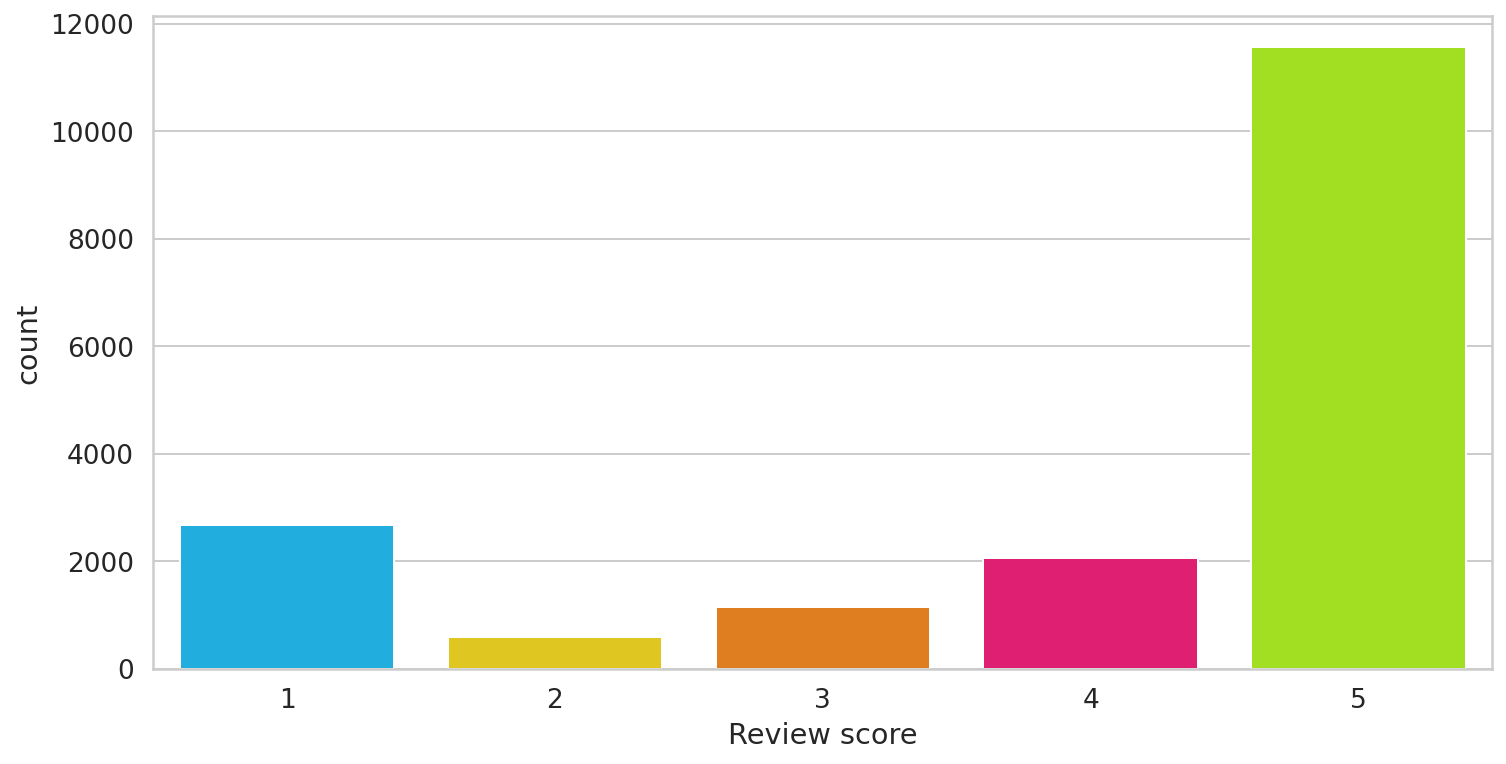

In [ ]:
sns.countplot(df.score)
plt.xlabel('Review score')

We have highly class imbalanced data. Most of the reviews have score 5 in the dataset.

### Let's convert our reviews into Positive & Negative sentiment.

In [ ]:
def to_sentiment(score):
  score=int(score)
  if score <=4:
    return 0
  else :
    return 1

df['sentiment']=df.score.apply(to_sentiment)
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,gp:AOqpTOE2Yr0uRwtSM19o3qq9rmIciKMII4oWvQ4X-TV...,Pankaj meena,https://lh3.googleusercontent.com/a-/AOh14GiBW...,wow,5,0,NaN,2020-08-10 03:15:48,NaN,NaN,newest,0,1
1,gp:AOqpTOEyZPR2_epCDBjuEGkFxMN8Uz7uqe8vju5pDDW...,Jesna sinaan Sinaan,https://lh3.googleusercontent.com/-KFcL-CA2eWY...,Super,5,0,NaN,2020-08-10 03:15:47,NaN,NaN,newest,0,1
2,gp:AOqpTOGTrphID0mo58x978-3DDrGXp_oilgqTtrkHvO...,Manoj Verma,https://lh3.googleusercontent.com/-wi1U7m9JVYU...,Majna verna,5,0,NaN,2020-08-10 03:15:44,NaN,NaN,newest,0,1
3,gp:AOqpTOH-6Qcb54ZFIl4MJon9dFtQHjHpLbSTFmw92P8...,MUKESH KUMAR DHRUW,https://lh3.googleusercontent.com/-nEokiW8fSXA...,Nice app,5,0,NaN,2020-08-10 03:14:51,NaN,NaN,newest,0,1
4,gp:AOqpTOGX6kF5IAfLaY_ZxwA7PvPwyxONwGN24JM0jrx...,Ananya Adak,https://lh3.googleusercontent.com/a-/AOh14Gi5w...,Nice,5,0,2.7.3.156,2020-08-10 03:14:42,NaN,NaN,newest,0,1


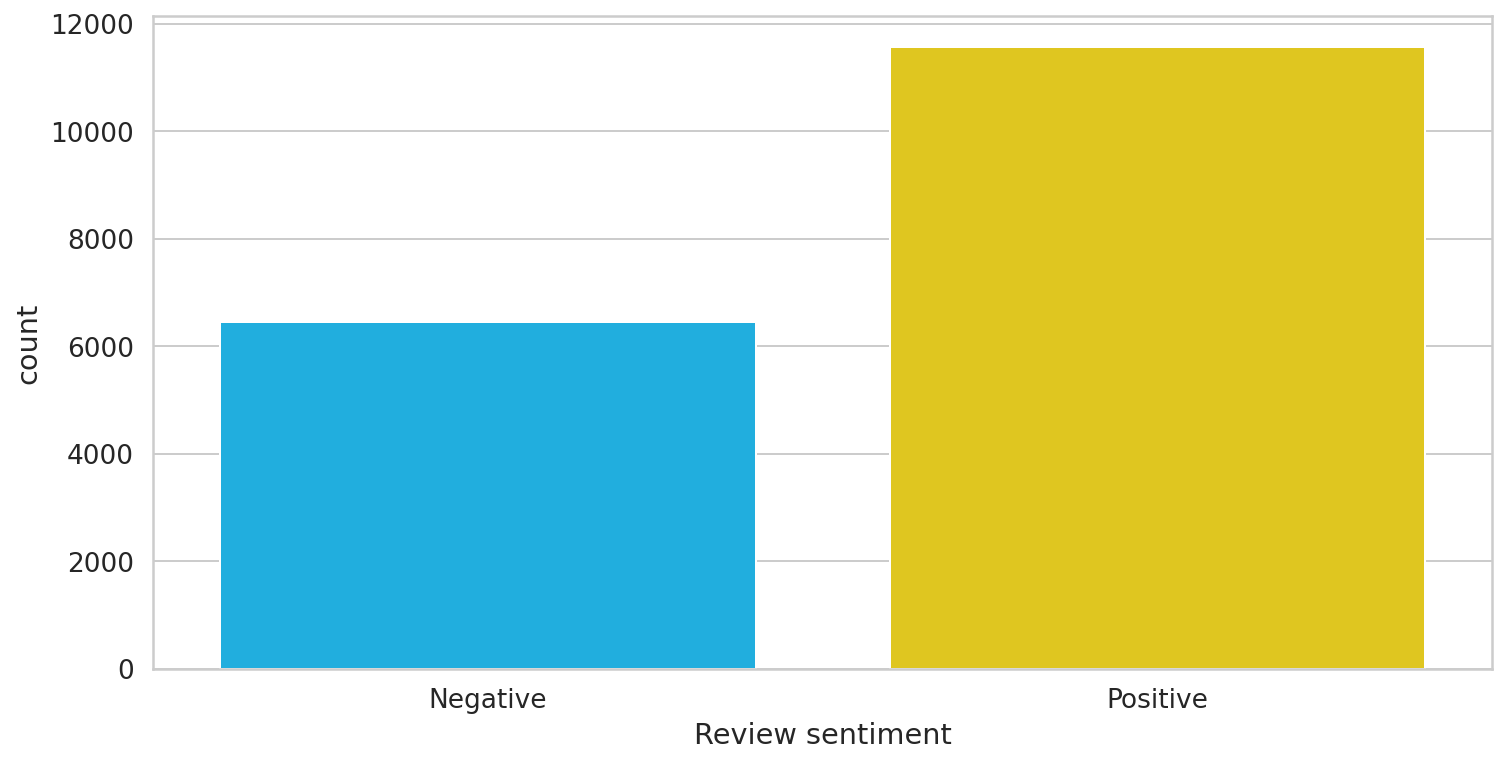

In [ ]:
ax=sns.countplot(df.sentiment)
plt.xlabel('Review sentiment')
class_names=['Negative','Positive']
ax.set_xticklabels(class_names)
plt.show()

Still classes are not balanced. Will proceed anyway..

In [ ]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,gp:AOqpTOE2Yr0uRwtSM19o3qq9rmIciKMII4oWvQ4X-TV...,Pankaj meena,https://lh3.googleusercontent.com/a-/AOh14GiBW...,wow,5,0,NaN,2020-08-10 03:15:48,NaN,NaN,newest,0,1
1,gp:AOqpTOEyZPR2_epCDBjuEGkFxMN8Uz7uqe8vju5pDDW...,Jesna sinaan Sinaan,https://lh3.googleusercontent.com/-KFcL-CA2eWY...,Super,5,0,NaN,2020-08-10 03:15:47,NaN,NaN,newest,0,1
2,gp:AOqpTOGTrphID0mo58x978-3DDrGXp_oilgqTtrkHvO...,Manoj Verma,https://lh3.googleusercontent.com/-wi1U7m9JVYU...,Majna verna,5,0,NaN,2020-08-10 03:15:44,NaN,NaN,newest,0,1
3,gp:AOqpTOH-6Qcb54ZFIl4MJon9dFtQHjHpLbSTFmw92P8...,MUKESH KUMAR DHRUW,https://lh3.googleusercontent.com/-nEokiW8fSXA...,Nice app,5,0,NaN,2020-08-10 03:14:51,NaN,NaN,newest,0,1
4,gp:AOqpTOGX6kF5IAfLaY_ZxwA7PvPwyxONwGN24JM0jrx...,Ananya Adak,https://lh3.googleusercontent.com/a-/AOh14Gi5w...,Nice,5,0,2.7.3.156,2020-08-10 03:14:42,NaN,NaN,newest,0,1


In [ ]:
# Split the data into train, test, & dev set
train_data, test_data = train_test_split(df[['content','sentiment']], test_size = 0.2, random_state=42)
test_data, dev_data = train_test_split(test_data, test_size = 0.5, random_state=42)

## **Data Processing**

DistilBERT do not process the raw text & it needs to be converted to numbers by tokenization.

#### Let's tokenize the text data

In [ ]:
Pre_trained_model='distilbert-base-uncased'

Let's load a pre-trained DistilBertTokenizer:

In [ ]:
tokenizer=DistilBertTokenizer.from_pretrained(Pre_trained_model)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Convert to list
train_content = train_data.content.tolist()
dev_content = dev_data.content.tolist()
test_content = test_data.content.tolist()

In [ ]:
# Create token ids (input ids) for each content
# Train dataset
train_input_ids = [tokenizer.encode(train_content[i],add_special_tokens = True) for i in range(0,len(train_content))]
# dev dataset
dev_input_ids = [tokenizer.encode(dev_content[i],add_special_tokens = True) for i in range(0,len(dev_content))]
# Test dataset
test_input_ids = [tokenizer.encode(test_content[i],add_special_tokens = True) for i in range(0,len(test_content))]

In [ ]:
### Padding & Truncating

from keras.preprocessing.sequence import pad_sequences    # Pad utility function to pad sequences to maximum length.
 
# Train dataset
Max_length = max([len(exp) for exp in train_input_ids])
print('\nPadding/truncating all sentences to %d values for train dataset...' % Max_length)
# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence
train_input_ids = pad_sequences(train_input_ids, maxlen=Max_length, dtype="long", 
                          value=0, truncating="post", padding="post")

# dev dataset
Max_length = max([len(exp) for exp in dev_input_ids])
print('\nPadding/truncating all sentences to %d values for dev dataset...' % Max_length)
dev_input_ids = pad_sequences(dev_input_ids, maxlen=Max_length, dtype="long", 
                          value=0, truncating="post", padding="post")

# Test dataset
Max_length = max([len(exp) for exp in test_input_ids])
print('\nPadding/truncating all sentences to %d values for test dataset' % Max_length)
test_input_ids = pad_sequences(test_input_ids, maxlen=Max_length, dtype="long", 
                          value=0, truncating="post", padding="post")
print('\n All are done.')


Padding/truncating all sentences to 164 values for train dataset...

Padding/truncating all sentences to 140 values for dev dataset...

Padding/truncating all sentences to 129 values for test dataset

 All are done.


In [ ]:
# Create attention masks

# Train dataset
train_attention_masks = [[int(token_id > 0) for token_id in content]
                         for content in train_input_ids]
# dev dataset
dev_attention_masks = [[int(token_id > 0) for token_id in content]
                         for content in dev_input_ids]
# Test dataset
test_attention_masks = [[int(token_id > 0) for token_id in content]
                         for content in test_input_ids]

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.

# input_ids
train_inputs = torch.tensor(train_input_ids)
dev_inputs = torch.tensor(dev_input_ids)
test_inputs = torch.tensor(test_input_ids)
# labels
train_labels = torch.tensor(train_data.sentiment.values)
dev_labels = torch.tensor(dev_data.sentiment.values)
test_labels = torch.tensor(test_data.sentiment.values)
# attention masks
train_masks = torch.tensor(train_attention_masks)
dev_masks = torch.tensor(dev_attention_masks)
test_masks = torch.tensor(test_attention_masks)

In [ ]:
# Create a DataLoader to load our datasets

batch_size = 8

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our dev set.
dev_data = TensorDataset(dev_inputs, dev_masks, dev_labels)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

### **DistilBertForSequenceClassification**

In [ ]:
# Number of classes / labels
n_classes = df.sentiment.nunique()

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(Pre_trained_model,num_labels = n_classes,
                                                          output_attentions = False,output_hidden_states = False )

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

In [ ]:
# Move to GPU
model = model.to(device) 

In [ ]:
# Define the optimizer & learning scheduler
epochs=2
# Define optimizer for updating weights
optimizer=AdamW(model.parameters(),lr=3e-5)
total_steps=len(train_dataloader)*epochs

# Scheduler for learning rate change
scheduler=get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
 # Define loss function & move it to GPU
loss_fn=nn.CrossEntropyLoss().to(device)

### Train our model

In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    totalCorrect = 0
    total = 0
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        totalCorrect += len(y_preds[y_preds==label])
        total += len(y_true)

    return {"accuracy":float(totalCorrect/total)}

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
possible_labels = ['Negative','Positive']

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Negative': 0, 'Positive': 1}

In [ ]:
def evaluate(dev_dataloader):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dev_dataloader:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dev_dataloader) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

**Start training...**

In [ ]:
# Store the average loss & accuracy after each epoch so we can plot them.
train_loss, train_acc = [], []
validation_loss , validation_acc = [], []

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    acc_train_total = 0

    progress_bar = tqdm(train_dataloader, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()

        # train predictions
        preds = outputs[1] 

        # Move logits and labels to CPU
        preds = preds.detach().cpu().numpy()
        label_ids = batch[2].to('cpu').numpy()

        # Calculate the accuracy for this batch.
        tmp_train_accuracy = flat_accuracy(preds, label_ids)
        # Accumulate the total accuracy.
        acc_train_total += tmp_train_accuracy

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        progress_bar.set_postfix({'training_acc': '{:.3f}'.format(tmp_train_accuracy/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(train_dataloader)
    acc_train_avg = acc_train_total/len(train_dataloader)

    # Append training loss & accuracy for each epoch
    train_acc.append(acc_train_avg)
    train_loss.append(loss_train_avg)
    tqdm.write(f'Training loss: {loss_train_avg}')
    tqdm.write(f'Training accuracy: {acc_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dev_dataloader)
    # Calculate validation accuracy
    val_acc = flat_accuracy(predictions, true_vals)
    val_f1 = f1_score_func(predictions, true_vals)
    # Append Validation loss & accuracy for each epoch
    validation_acc.append(val_acc)
    validation_loss.append(val_loss)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Validation accuracy: {val_acc}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1800 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.4717061628235711
Training accuracy: 0.80125
Validation loss: 0.37371524738768735
Validation accuracy: 0.8566666666666667
F1 Score (Weighted): 0.8498340596251956


Epoch 2:   0%|          | 0/1800 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.3369984793523326
Training accuracy: 0.8759027777777778
Validation loss: 0.36100458228753673
Validation accuracy: 0.8711111111111111
F1 Score (Weighted): 0.865996870711767


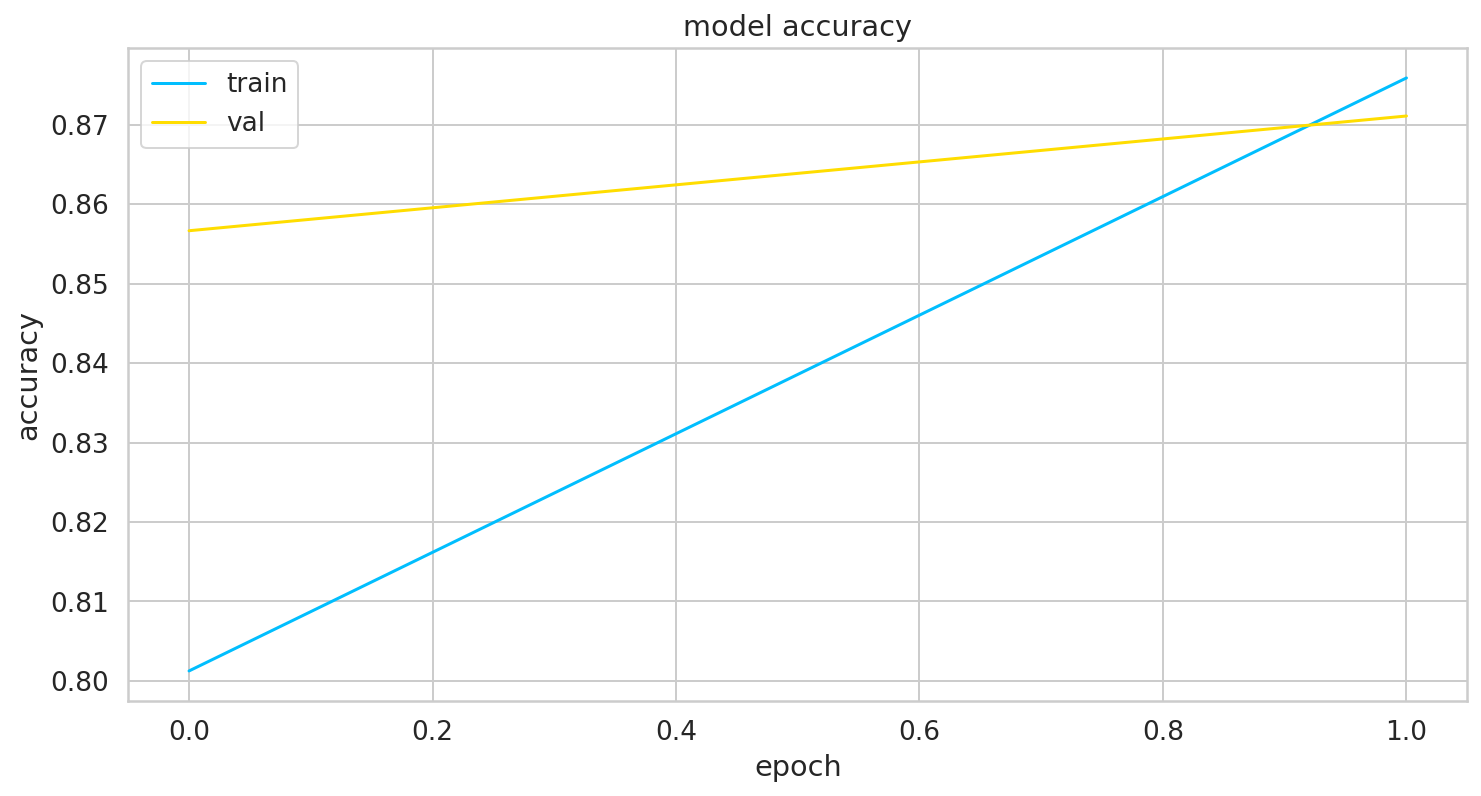

In [ ]:
# Plot accuracy curve
plt.plot(train_acc)
plt.plot(validation_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

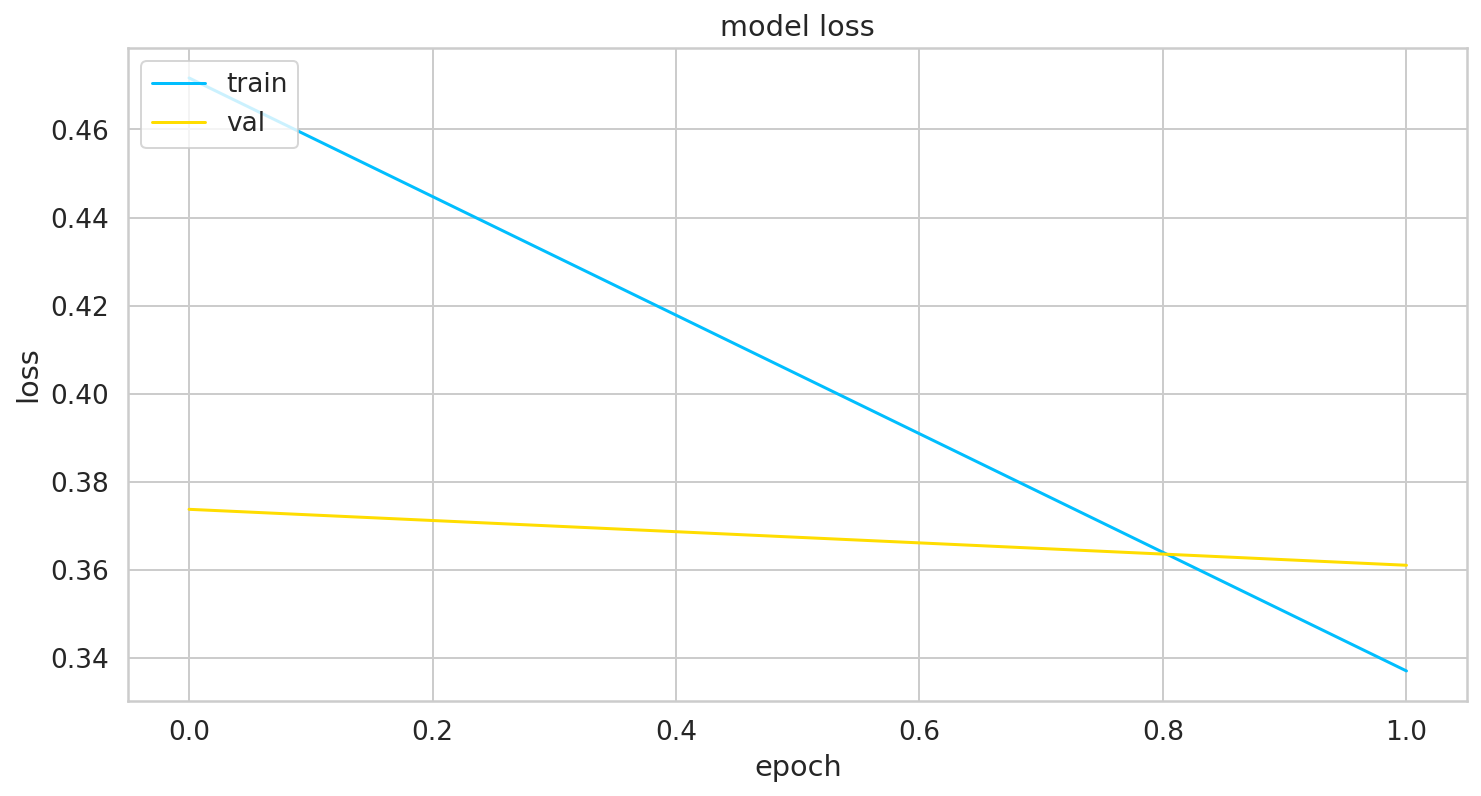

In [ ]:
# Plot loss curve
plt.plot(train_loss)
plt.plot(validation_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Initializing the "model" again

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(Pre_trained_model,num_labels = n_classes,
                                                          output_attentions = False,output_hidden_states = False )
model = model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

In [ ]:
model.load_state_dict(torch.load(f'finetuned_BERT_epoch_{epochs}.model', map_location=torch.device('cpu')))

<All keys matched successfully>

Generating predictions

In [ ]:
_, predictions, true_vals = evaluate(test_dataloader)

In [ ]:
accuracy_per_class(predictions, true_vals)

Class: Negative
Accuracy: 449/646

Class: Positive
Accuracy: 1116/1154



{'accuracy': 0.8694444444444445}

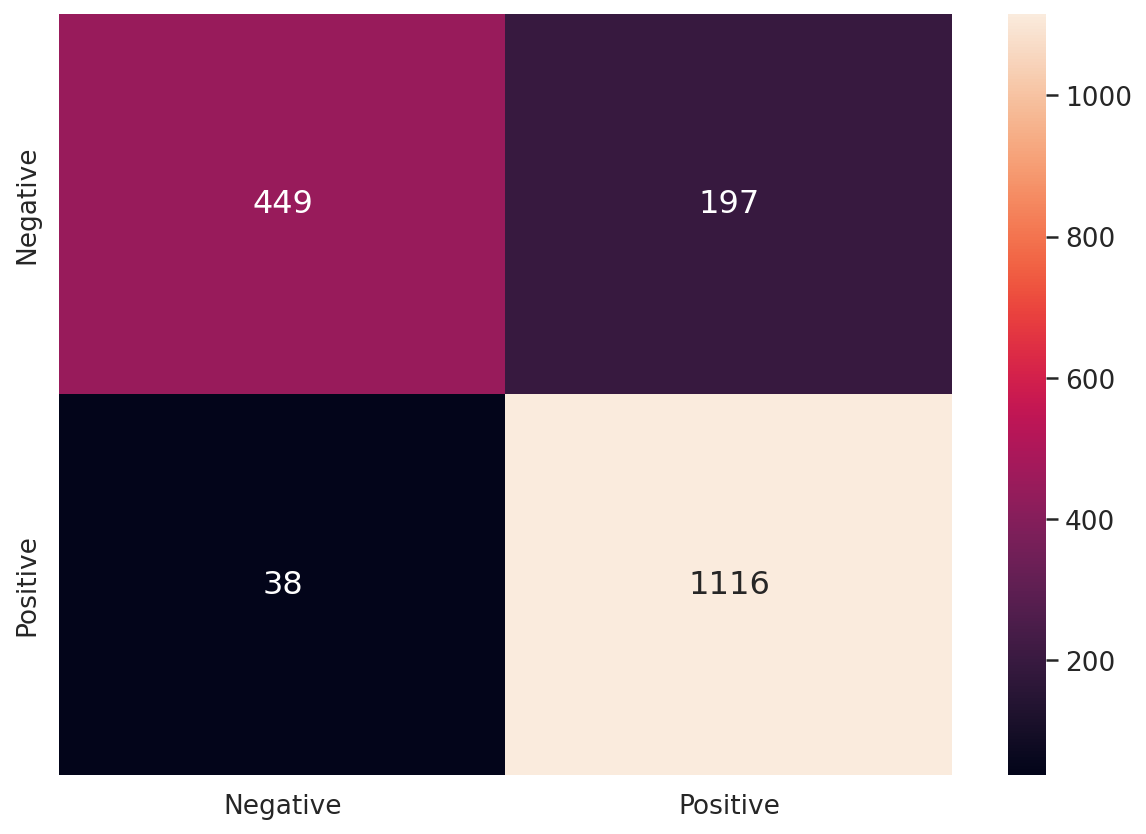

In [ ]:
from sklearn import metrics
# Confusion matrix
matrix = metrics.confusion_matrix(true_vals, predictions.argmax(axis=1))
l = ['Negative', 'Positive']
df_cm = pd.DataFrame(matrix, index = [i for i in l],
                  columns = [i for i in l])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, xticklabels=l, yticklabels=l, fmt='g')

In [ ]:
# Classification report
classReport = metrics.classification_report(true_vals, predictions.argmax(axis=1),target_names=l)
print(classReport)

              precision    recall  f1-score   support

    Negative       0.92      0.70      0.79       646
    Positive       0.85      0.97      0.90      1154

    accuracy                           0.87      1800
   macro avg       0.89      0.83      0.85      1800
weighted avg       0.88      0.87      0.86      1800



### ROC curve

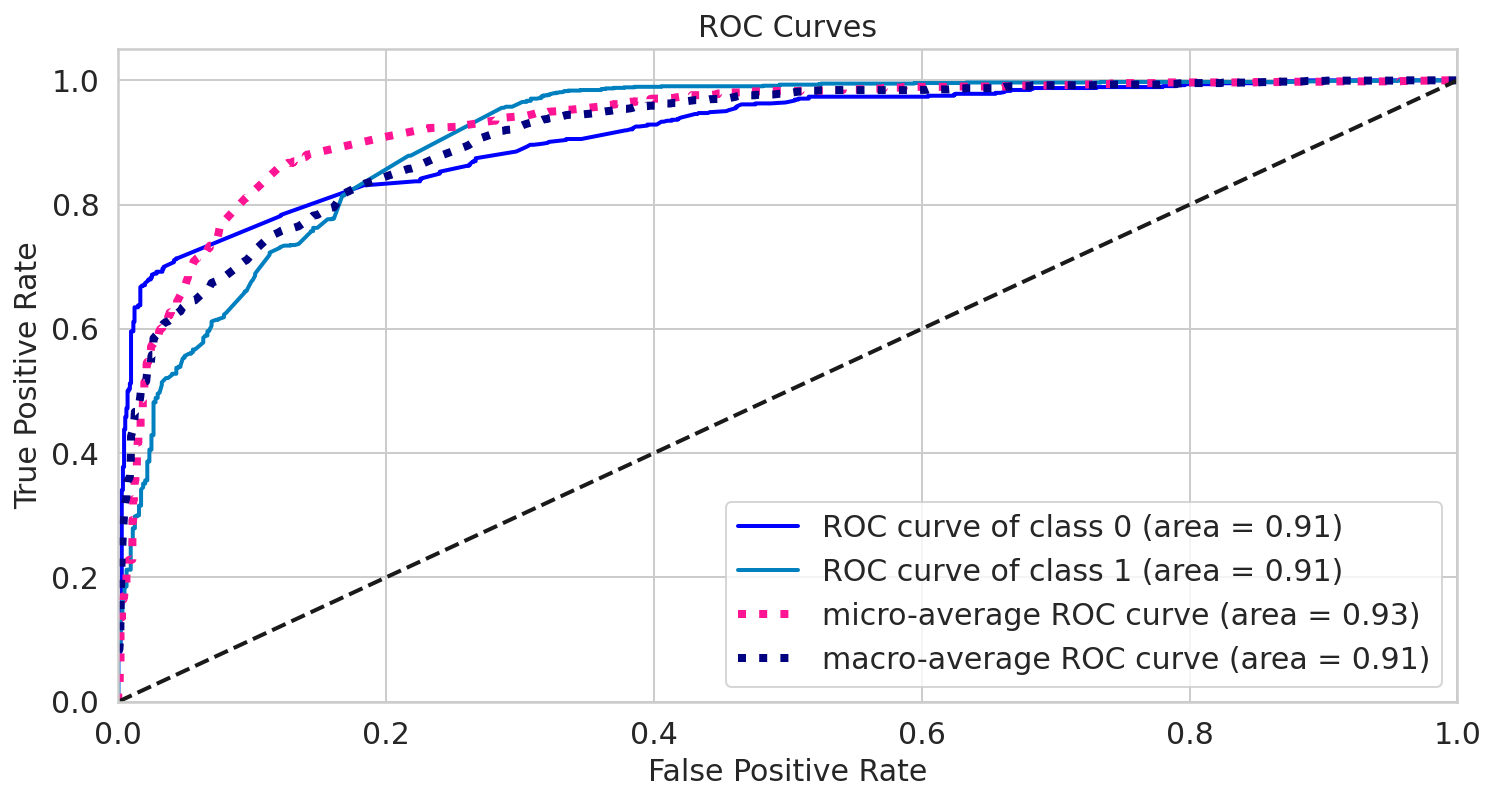

In [ ]:
import scikitplot as skplt
skplt.metrics.plot_roc(true_vals, predictions, figsize = (12,6), text_fontsize = 15, title_fontsize = 15,
                      cmap = 'winter')
plt.show()

## Predicting on Raw text

Let's us use our model to predict sentiment on raw text:

In [ ]:
review_text='Fake Fake Fake Fake Fake, Please be aware of them, they are very dangerous people please be aware of them. \
They ask your pan and aadhara number for interview, the ppl who calls are unprofessional they talk rubbish and try to trap you in pit'

Now use the tokenizer to encode the raw text:

In [ ]:
encoded_review=tokenizer.encode_plus(
    review_text,
    max_length=Max_length,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

Let's get predictions from our model:

In [ ]:
import torch.nn.functional as F
input_ids=encoded_review['input_ids'].to(device)
attention_mask=encoded_review['attention_mask'].to(device)

output=model(input_ids,attention_mask)
logits = output.logits
preds= F.softmax(logits)
pred = preds.argmax(1)
print(f'Review_text : {review_text}')
print(f'Sentiment: {class_names[pred]}')

Review_text : Fake Fake Fake Fake Fake, Please be aware of them, they are very dangerous people please be aware of them. They ask your pan and aadhara number for interview, the ppl who calls are unprofessional they talk rubbish and try to trap you in pit
Sentiment: Negative


Wow, our model is generalizing well. This model can be fine tuned further to improve its performance.

## Save our model


In [ ]:
path="Sentiment_Analysis_DistilBert.bin"
torch.save(model.state_dict(),path)